In [2]:
# %matplotlib widget

import sys
sys.path.append("./../scripts")
import PandemiXFunctions as pf
import PandemiXModelFunctions as pmf

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['figure.facecolor'] = (1,1,1,1)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

import datetime
             
from scipy.integrate import cumtrapz
# int_I = cumtrapz(np.exp(u_H*ts)*Is,ts, initial=0)
# Hs = np.exp(-u_H*ts) * (r_chr*pars_full['gamma']*int_I + k) 

In [3]:
# Model with explicit symptomatic category and keeping track of whether recovered were found or not
modelMeta = ({
     'beta * S * (P+A)' : ['S','E1'],
     'gamma * E1' : ['E1','E2'],
     'gamma * E2' : ['E2','P'],
     'gamma * rho * P' : ['P','I'],
     'gamma * (1-rho) * P' : ['P','A'],
     'nu * A' : ['A',None],
     'nu * Q' : ['Q','Rp'],
     # 'nu * I' : ['I',None],
     'nu * I' : ['I','Rp'], # Assuming that symptomatic cases get tested, but aren't included in Q 
     'tau * E2' : ['E2','Q'],
     'tau * P'  : ['P','Q'],
     'tau * A'  : ['A','Q'],
     # 'tau * I'  : ['I','Q'], # Testing of symptomatic cases
     # 'tauInf * I'  : ['I','Q'], # Testing of symptomatic cases
     
},
['S','E1','E2','P','A','Q','I','Rp'],['beta','gamma','nu','rho','tau'])


(0.0, 1.0)

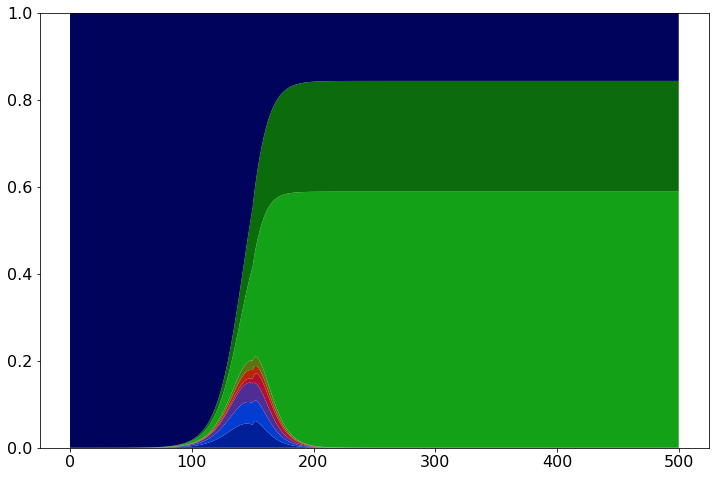

In [35]:
# Initialize everything

DKpop = 5800000
iniExp = 10 

E1_0 = iniExp/DKpop 
E2_0 = 0
P_0 = 0
A_0 = 0
Q_0 = 0
I_0 = 0
R_0 = 0
Rp_0 = 0
S_0 = 1 - E1_0 - E2_0 - P_0 - A_0 - Q_0 - R_0 - I_0 - Rp_0

# init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':Q_0,'I':I_0,'Rp':Rp_0}
init = {'S' : S_0,'E1':E1_0,'E2':0 , 'P':0,'A':0,'Q':0,'I':0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
# rho = 0.25
beta = 3*5/7
tau = 0.95 * 1/3
beta  = 4
tau = 0.55
beta  = 1.5
beta  = 1.2
beta = 1.7*gamma
tau = 0.03
tau2 = 0.1
beta2 = 1.6*beta
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 500 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])

tChange = 150
changeTest = pmf.Change(tChange,SetParameters={'tau':tau2,'beta':beta2})
sch1.addChange(changeTest)
# tChange = 50
# changeTest = pmf.Change(tChange,SetParameters={'tau':tau2})
# sch1.addChange(changeTest)
# tChange = 80
# changeTest2 = pmf.Change(tChange,SetParameters={'tau':tau3})
# sch1.addChange(changeTest2)

sch1.simulate(tRes=1000)

Rs = 1- sch1.result.y.sum(axis=0)

cmap = pf.getColormapFromList(['xkcd:dark blue','xkcd:blue','xkcd:red','xkcd:green','xkcd:dark green'],10)

fig,ax1 = plt.subplots()
ax1.stackplot(sch1.result.t,
        sch1.result.E1,
        sch1.result.E2,
        sch1.result.P,
        sch1.result.Q,
        sch1.result.A,
        sch1.result.I,
        sch1.result.Rp,
        Rs,
        sch1.result.S, 
        colors=[cmap(1),cmap(2),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7),cmap(8),cmap(0)],
        )

ax1.set_ylim([0,1])
# # ax1.plot(sch1.result.t,sch1.result.E1)
# # ax1.plot(sch1.result.t,sch1.result.Rp)
# ax1.plot(sch1.result.t,sch1.result.Rp+Rs)
# ax1.plot(sch1.result.t,sch1.result.S)
# ax1.plot(sch1.result.t,sch1.result.Q)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.A)
# ax1.plot(sch1.result.t,sch1.result.Q+sch1.result.A+sch1.result.I)

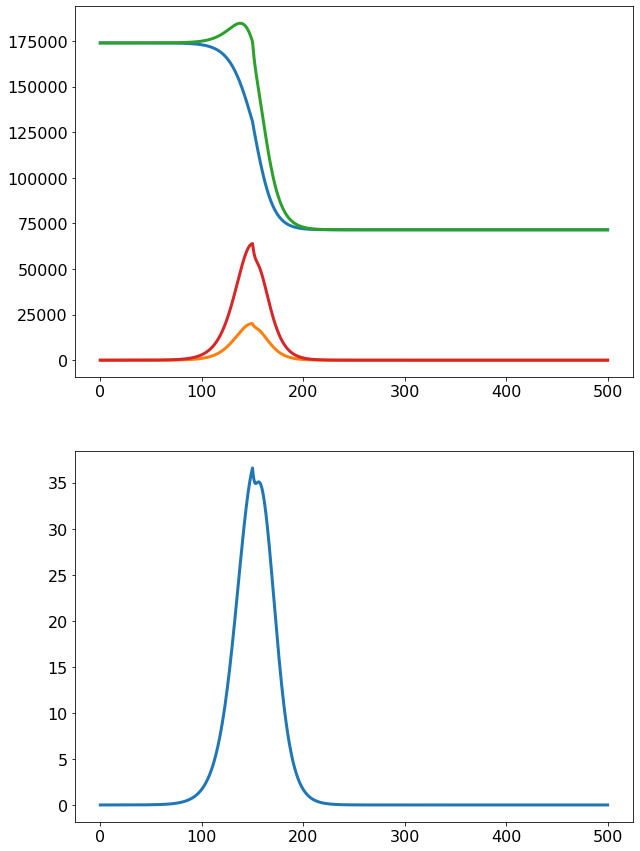

In [36]:

curSch = sch1
curPop = DKpop
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)

curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)

testSymp = cumtrapz(curInf,ts,initial=0)
# fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,15))
fig,(ax,ax2) = plt.subplots(2,1,figsize=(10,15))
# ax.plot(ts,curTest)
ax.plot(ts,curPop*(curTestAll))
ax.plot(ts,curPop*(curTestPos))
ax.plot(ts,curPop*(curTestAll+curInf))
ax.plot(ts,curPop*(curInf+curTestPos))
# ax.plot(ts,curInf*curPop)
ax2.plot(ts,100*posPct)
# ax2.plot(ts,100*(Rp/(Rp+Rn)))

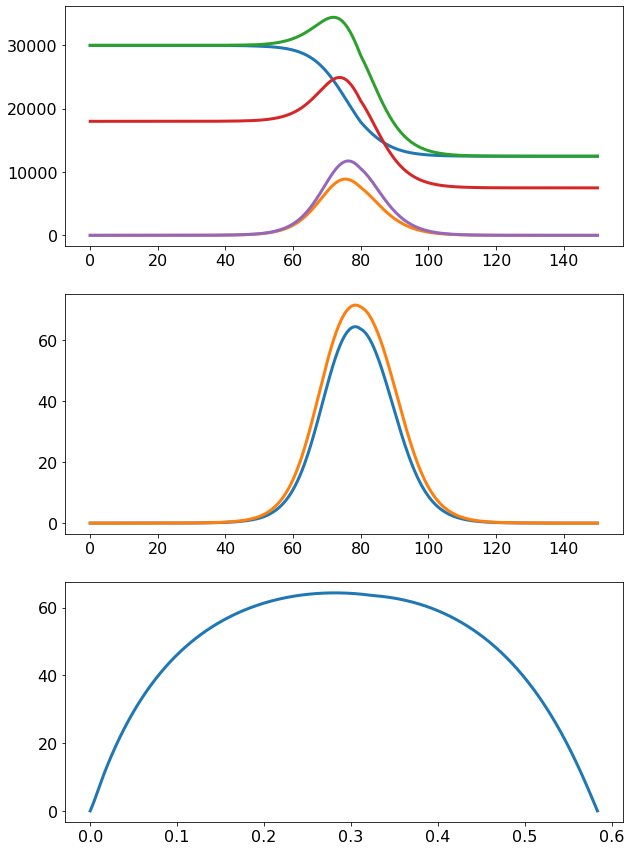

In [5]:
# cumtrapz(newInf,ts,initial=0)
curSch = sch1
curPop = 600000
ts = curSch.result.t
Rp = curSch.result.Rp
Rn = 1-curSch.result.y.sum(axis=0)
curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)
curTestAll2 = tau2 * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestPos2 = tau2*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)
posPct2 = (curTestPos2+curInf)/(curTestAll2+curInf)

testSymp = cumtrapz(curInf,ts,initial=0)
# fig,(ax,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(10,15))
fig,(ax,ax2,ax3) = plt.subplots(3,1,figsize=(10,15))
# ax.plot(ts,curTest)
ax.plot(ts,curPop*(curTestAll))
ax.plot(ts,curPop*(curTestPos))
ax.plot(ts,curPop*(curTestAll+curInf))
ax.plot(ts,curPop*(curTestAll2+curInf))
ax.plot(ts,curPop*(curInf))
# ax.plot(ts,curInf*curPop)
ax2.plot(ts,100*posPct)
ax2.plot(ts,100*posPct2)
# ax2.plot(ts,100*(Rp/(Rp+Rn)))

# ax3.plot(ts,cumtrapz(curTestAll,ts,initial=0))
# ax3.plot(ts,cumtrapz(curTestAll+curInf,ts,initial=0))

ax3.plot(curSch.result.Rp,100*posPct)

In [6]:
def getBetaFromTauAndSigma(tau,sigma,pars):

    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']

    estiTE = (1-sigma)/(gamma+tau)
    estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    beta = -np.log(sigma)/(estiTP+estiTA)
    

    return beta 

In [7]:
def calcFoundRatio(pars):
    gamma = pars['gamma']
    nu = pars['nu']
    rho = pars['rho']
    tau = pars['tau']

    # sigma = 0.19 
    # estiTE = (1-sigma)/(gamma+tau)
    # estiTP = (1-sigma - tau*estiTE)/(gamma+tau)
    # estiTA = (1-sigma - (gamma*rho+tau)*estiTP - tau*estiTE)/(nu+tau)

    # toReturn = 1- (nu*estiTA)/(1-sigma)

    toReturn = 1 - (nu/(nu+tau))*(1-tau/(gamma+tau))*(1-(gamma*rho+tau)/(gamma+tau))
    return toReturn

# print(calcFoundRatio(newPars))
print(calcFoundRatio(pars))

0.671241883784006


In [8]:
# tauRange = np.arange(0,0.21,0.1)
# betaRange = np.arange(1,2.1,0.2)
tauRange = np.linspace(0,1,4)
betaRange = np.linspace(0.9,3,3)*gamma

XX,YY = np.meshgrid(tauRange,betaRange)
ZZ = np.zeros(XX.shape)
ZZfin = np.zeros(XX.shape)

for i,tau in enumerate(tauRange):
    pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
    finTau = calcFoundRatio(pars)
    # ZZfin[i,:] = finTau
    ZZfin[:,i] = finTau

    for j,beta in enumerate(betaRange):        
        pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}
        
        tEnd = 2000
        sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
        sch1.simulate(tRes=1000)
        Rs = 1- sch1.result.y.sum(axis=0)
        Rp = sch1.result.Rp

        curRatio = Rp/(Rs+Rp)
        # ZZ[i,j] = curRatio[-1]
        ZZ[j,i] = curRatio[-1]


C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12724/721231316.py:25: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rs+Rp)


In [9]:
print(ZZ) 
print(ZZfin)
print(np.round(ZZ*DKpop)) 
print(np.round(ZZfin*DKpop))

[[0.5        0.93748924 0.98146526 0.99218316]
 [0.5        0.9374983  0.98147364 0.99217478]
 [0.5        0.93750009 0.98147    0.99218447]]
[[0.5        0.9375     0.98148148 0.9921875 ]
 [0.5        0.9375     0.98148148 0.9921875 ]
 [0.5        0.9375     0.98148148 0.9921875 ]]
[[2900000. 5437438. 5692498. 5754662.]
 [2900000. 5437490. 5692547. 5754614.]
 [2900000. 5437501. 5692526. 5754670.]]
[[2900000. 5437500. 5692593. 5754688.]
 [2900000. 5437500. 5692593. 5754688.]
 [2900000. 5437500. 5692593. 5754688.]]


C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12724/4275601128.py:14: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rs+Rp)
C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12724/4275601128.py:32: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rs+Rp)


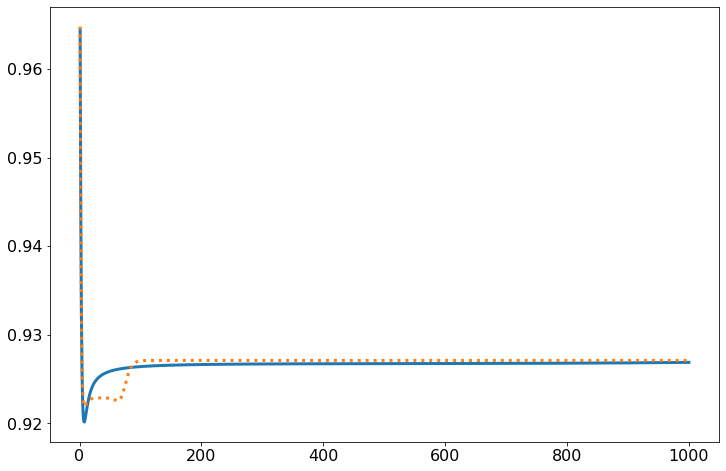

In [10]:
# beta = 1.1*gamma
beta = 1
tau = 0.05
# tau= 0
tau = 0.3
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

tEnd = 1000
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)
Rs = 1- sch1.result.y.sum(axis=0)
Rp = sch1.result.Rp

curRatio = Rp/(Rs+Rp)
fig,ax = plt.subplots()
# ax.plot(sch1.result.t,sch1.result.Rp)
# ax.plot(sch1.result.t,Rs)
ax.plot(sch1.result.t,curRatio)

# beta = 2.5*gamma
beta2 = 3
# tau = 0.05
# tau= 0
pars2 = {'beta':beta2,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

tEnd = 1000
sch2 = pmf.Scheme(modelMeta,init,pars2,0,tEnd,Changes=[])
sch2.simulate(tRes=1000)
Rs = 1- sch2.result.y.sum(axis=0)
Rp = sch2.result.Rp

curRatio = Rp/(Rs+Rp)
# fig,ax = plt.subplots()
# ax.plot(sch2.result.t,sch2.result.Rp)
# ax.plot(sch2.result.t,Rs)
ax.plot(sch2.result.t,curRatio,':')
# ax.plot(sch2.result.t,Rs+Rp,'--')

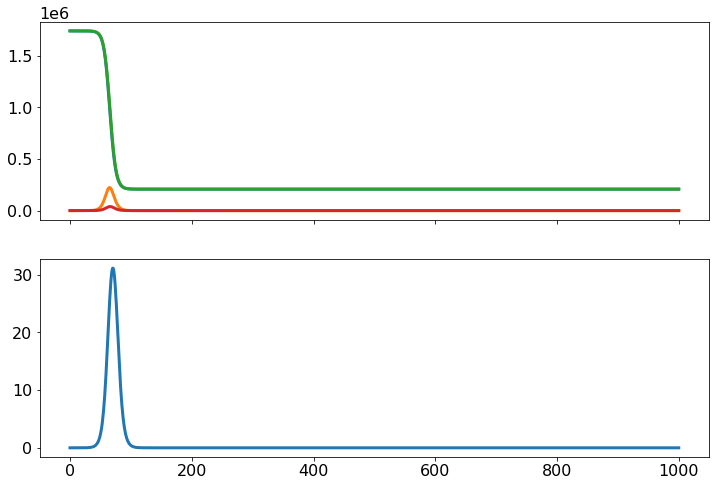

In [11]:
# cumtrapz(newInf,ts,initial=0)
curSch = sch2
ts = curSch.result.t
Rn = 1-curSch.result.y.sum(axis=0)
curInf = gamma * rho * curSch.result.P
curTest = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A )
curTestAll = tau * (curSch.result.S + curSch.result.E1+ curSch.result.E2+ curSch.result.P + curSch.result.A + Rn)

curTestPos = tau*( curSch.result.E2+ curSch.result.P + curSch.result.A )

posPct = (curTestPos+curInf)/(curTestAll+curInf)

testSymp = cumtrapz(curInf,ts,initial=0)
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)
# ax.plot(ts,curTest)
ax.plot(ts,DKpop*(curTestAll))
ax.plot(ts,DKpop*(curTestPos))
ax.plot(ts,DKpop*(curTestAll+curInf))
ax.plot(ts,DKpop*(curInf))
# ax.plot(ts,curInf*DKpop)
ax2.plot(ts,100*posPct)

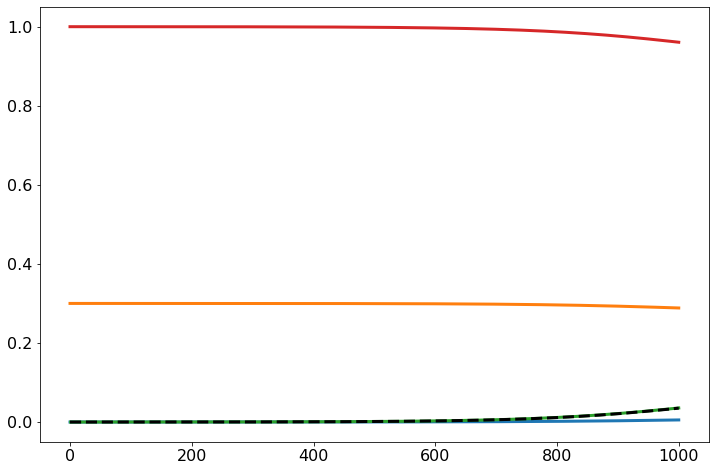

In [12]:
fig,ax = plt.subplots()
ts = sch1.result.t
# newInf = beta * sch1.result.S * (sch1.result.P + sch1.result.A)
newInf = gamma * rho * sch1.result.P
curTest = tau * (sch1.result.S + sch1.result.E1+ sch1.result.E2+ sch1.result.P + sch1.result.A)
# ax.plot(ts,cumtrapz(,ts))
ax.plot(ts,cumtrapz(newInf,ts,initial=0)) 
ax.plot(ts,curTest)
ax.plot(ts[1:],cumtrapz(newInf,ts)+cumtrapz(tau*(sch1.result.E2+sch1.result.P+sch1.result.A),ts)) 
ax.plot(ts,sch1.result.Rp,'k--')
ax.plot(ts,sch1.result.S)

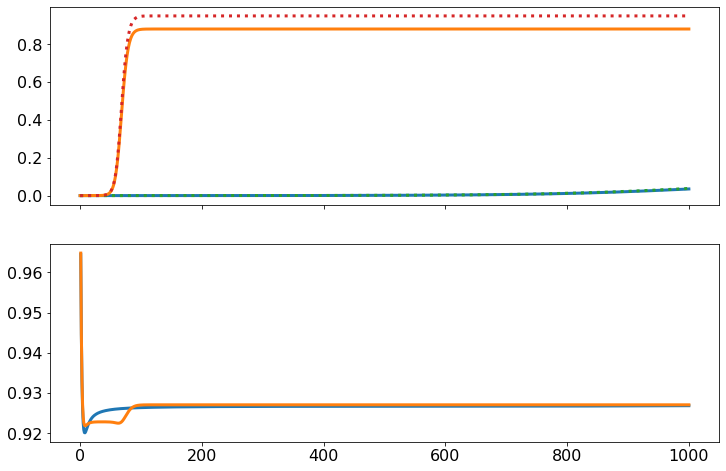

In [13]:
fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

Rs1 = 1-sch1.result.y.sum(axis=0)
Rs2 = 1-sch2.result.y.sum(axis=0)

# ax.plot(sch1.result.t[1:],nu*cumtrapz(sch1.result.I,sch1.result.t)+nu*cumtrapz(sch1.result.Q,sch1.result.t))
# ax.plot(sch2.result.t[1:],nu*cumtrapz(sch2.result.I,sch2.result.t)+nu*cumtrapz(sch2.result.Q,sch2.result.t))
ax.plot(sch1.result.t,sch1.result.Rp)
ax.plot(sch2.result.t,sch2.result.Rp)
ax.plot(sch1.result.t,sch1.result.Rp+Rs1,':')
ax.plot(sch2.result.t,sch2.result.Rp+Rs2,':')

ax2.plot(sch1.result.t[1:],sch1.result.Rp[1:]/(sch1.result.Rp[1:]+Rs1[1:]))
ax2.plot(sch2.result.t[1:],sch2.result.Rp[1:]/(sch2.result.Rp[1:]+Rs2[1:]))
# ax2.plot(sch1.result.t,sch1.result.Rp/(sch1.result.Rp+Rs1))
# ax2.plot(sch2.result.t,sch2.result.Rp/(sch2.result.Rp+Rs2))
# ax2.plot(sch1.result.t,(sch1.result.Rp+Rs1))
# ax2.plot(sch2.result.t,(sch2.result.Rp+Rs2))
# ax2.plot(sch1.result.t,Rs1)
# ax2.plot(sch1.result.t,sch1.result.Rp)
# ax2.plot(sch2.result.t,Rs2)
# ax2.plot(sch2.result.t,sch2.result.Rp)

C:\Users\Rasmus\AppData\Local\Temp/ipykernel_12724/1867966480.py:12: RuntimeWarning: invalid value encountered in true_divide
  curRatio = Rp/(Rs+Rp)


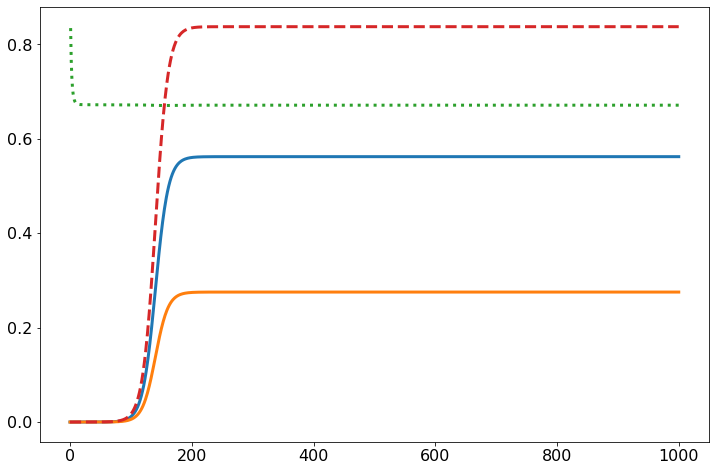

In [14]:
beta = 2*gamma
tau = 0.05
# tau= 0
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}

tEnd = 1000
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])
sch1.simulate(tRes=1000)
Rs = 1- sch1.result.y.sum(axis=0)
Rp = sch1.result.Rp

curRatio = Rp/(Rs+Rp)
fig,ax = plt.subplots()
ax.plot(sch1.result.t,sch1.result.Rp)
ax.plot(sch1.result.t,Rs)
ax.plot(sch1.result.t,curRatio,':')
ax.plot(sch1.result.t,Rs+Rp,'--')

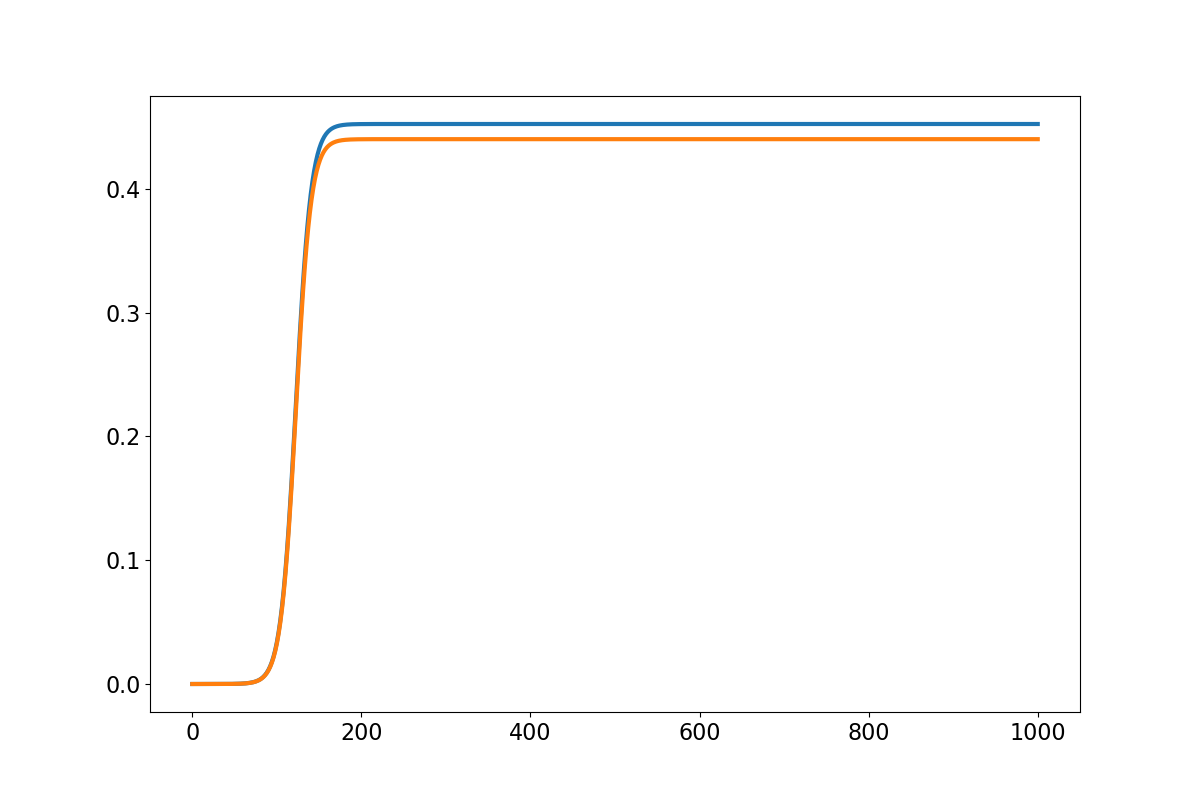

In [154]:
fig,ax = plt.subplots()
ax.plot(sch1.result.t,sch1.result.Rp)
ax.plot(sch1.result.t,Rs)

In [344]:
# Initialize everything

# curPop = 600000
curPop = 5800000
iniExp = 10 
iniExp = 10000 
curIni = iniExp/curPop 

# E1_0 = iniExp/curPop 
# E2_0 = 0
# P_0 = 0
# A_0 = 0
E1_0 = curIni/4
E2_0 = curIni/4
P_0 = curIni/4
A_0 = curIni/8
Q_0 = 0
I_0 = curIni/8
R_0 = 0
Rp_0 = 0
S_0 = 1 - E1_0 - E2_0 - P_0 - A_0 - Q_0 - R_0 - I_0 - Rp_0

# init = {'S' : S_0,'E1':E1_0,'E2':E2_0 , 'P':P_0,'A':A_0,'Q':Q_0,'I':I_0,'Rp':Rp_0}
init = {'S' : S_0,'E1':E1_0,'E2':0 , 'P':0,'A':0,'Q':0,'I':0,'Rp':0}

gamma = 1/3
nu = 1/3
rho = 0.5
# rho = 0.25
# beta = 3*5/7
# tau = 0.95 * 1/3
# beta  = 4
# tau = 0.55
beta  = 1.5
# beta  = 1.05
beta = 2 * gamma
beta = 1.8 * gamma
tau = 0.05
tau2 = 0.03
tau3 = 0.02
pars = {'beta':beta,'nu':nu,'gamma':gamma,'rho':rho,'tau':tau}


tEnd = 150 
sch1 = pmf.Scheme(modelMeta,init,pars,0,tEnd,Changes=[])


tChange = 40
changeTest2 = pmf.Change(tChange,SetParameters={'tau':tau2})
sch1.addChange(changeTest2)

tChange = 80
changeTest3 = pmf.Change(tChange,SetParameters={'tau':tau3})
sch1.addChange(changeTest3)

sch1.simulate(tRes=1000)

ts = sch1.result.t 
Rs = 1- sch1.result.y.sum(axis=0)
Rn = 1- sch1.result.y.sum(axis=0)


In [345]:
# plt.figure()
# plt.plot(ts,tauVec)

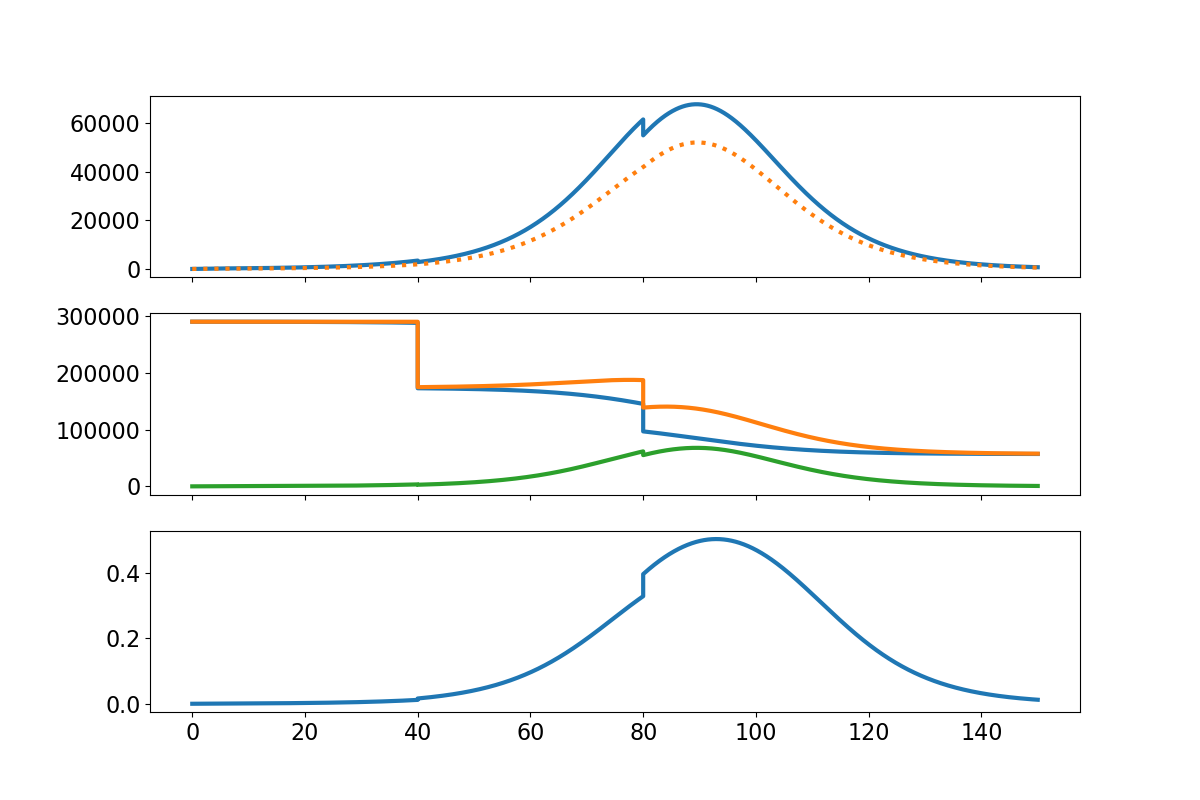

In [346]:
tauVec = np.concatenate([tau*np.ones((1000,)),tau2*np.ones((1000,))])
tauVec = np.concatenate([tau*np.ones((1000,)),tau2*np.ones((1000,)),tau3*np.ones((1000,))])

newInf = gamma*rho*sch1.result.P 
newQua = tauVec*(sch1.result.E2+sch1.result.P+sch1.result.A)
curTestVol = tauVec*(sch1.result.S+sch1.result.E1+sch1.result.E2+sch1.result.P+sch1.result.A+Rn)
curTestSymp = newInf 
curTestVolPos = tauVec*(sch1.result.E2+sch1.result.P+sch1.result.A)

fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
# # ax2.plot(sch1.result.t,curPop*(sch1.result.Q+sch1.result.I))
ax1.plot(sch1.result.t,curPop*(newQua+newInf))
ax1.plot(sch1.result.t,curPop*(newInf),':')

ax2.plot(ts,curPop*(curTestVol))
ax2.plot(ts,curPop*(curTestVol+curTestSymp))
ax2.plot(ts,curPop*(curTestVolPos+curTestSymp))

ax3.plot(ts,(curTestVolPos+curTestSymp)/(curTestVol+curTestSymp))


In [ ]:

# cmap = pf.getColormapFromList(['xkcd:dark blue','xkcd:blue','xkcd:red','xkcd:green','xkcd:dark green'],10)

fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
# ax1.stackplot(sch1.result.t,
#         sch1.result.E1,
#         sch1.result.E2,
#         sch1.result.P,
#         sch1.result.Q,
#         sch1.result.A,
#         sch1.result.I,
#         sch1.result.Rp,
#         Rs,
#         sch1.result.S, 
#         colors=[cmap(1),cmap(2),cmap(3),cmap(4),cmap(5),cmap(6),cmap(7),cmap(8),cmap(0)],
#         )

# ax1.set_ylim([0,1])


newInf = gamma*rho*sch1.result.P 
newQua = tau*(sch1.result.E2+sch1.result.P+sch1.result.A)
# # ax2.plot(sch1.result.t,curPop*(sch1.result.Q+sch1.result.I))
ax1.plot(sch1.result.t,curPop*(newQua+newInf))
ax1.plot(sch1.result.t,curPop*(newInf),':')


curTestVol = tau*(sch1.result.S+sch1.result.E1+sch1.result.E2+sch1.result.P+sch1.result.A+Rn)
curTestSymp = newInf 
curTestVolPos = tau*(sch1.result.E2+sch1.result.P+sch1.result.A)

ax2.plot(ts,curPop*(curTestVol))
ax2.plot(ts,curPop*(curTestVol+curTestSymp))
ax2.plot(ts,curPop*(curTestVolPos+curTestSymp))

ax3.plot(ts,(curTestVolPos+curTestSymp)/(curTestVol+curTestSymp))